# 데이터 분석
1. 새로운 폴더 생성 및 분석할 c2m2 분석 txt 파일 옮기기
2. 폴더 경로 입력
3. 기준 입력

In [3]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [6]:
def getRMSE():
    # 경로 입력
    folder = input("폴더 경로를 입력해주세요 ")
    f_list = [file for file in os.listdir(folder) if file.endswith('.txt')]

    print(f_list)
    dlist = []
    fnamelst = []
    for i in range(len(f_list)):
        fnamelst.append(f_list[i][:-4])
    print(fnamelst)

    dnamelst = fnamelst.copy()

    for i in range(len(dnamelst)):
        dnamelst[i] = dnamelst[i]+"df"

    fpath = glob.glob(folder+'/*.txt')

    for j in range(len(fnamelst)):
        fname = fnamelst[j]
        #print('파일 이름 : ',fname)

    #print(fpath)

    # 기준 입력
    #k = [[],[],[],[]]
    #for i in range(4):
        #k[i].append(float(input(str(i+1) + ' 번째 x 시작 ')))
        #k[i].append(float(input(str(i+1) + ' 번째 x 끝 ')))
        #k[i].append(float(input(str(i+1) + ' 번째 y 시작 ')))
        #k[i].append(float(input(str(i+1) + ' 번째 y 끝 ')))

    for z in range(len(f_list)):
        filepath = fpath[z]
        dfname = dnamelst[z]
        rname = fnamelst[z]

        # 함수 시작
        locals()[dfname] = pd.read_table(filepath, encoding="CP949")
        df = locals()[dfname]


        if(len(locals()[dfname].columns) == 4):
            locals()[dfname] = locals()[dfname].rename(columns = {'//X':'X', 'C2M signed distances':'C2M'})
            #df = df.drop(['R','G','B','Intensity'], axis=1)
            locals()[dfname]['C2M^'] = locals()[dfname]['C2M'] * locals()[dfname]['C2M']
            locals()[dfname]['C2M^'] = locals()[dfname]['C2M^']*1000
            locals()[dfname]['wall'] = "None"

        if(len(locals()[dfname].columns) == 9):
            locals()[dfname] = locals()[dfname].rename(columns = {'//X':'X'})
            locals()[dfname].drop([locals()[dfname].columns[3], locals()[dfname].columns[4], locals()[dfname].columns[5],
                    locals()[dfname].columns[7], locals()[dfname].columns[8]], axis=1, inplace=True)
            locals()[dfname] = locals()[dfname].rename(columns ={locals()[dfname].columns[3]:'C2M'})
            locals()[dfname]['C2M^'] = locals()[dfname]['C2M'] * locals()[dfname]['C2M']
            locals()[dfname]['wall'] = "None"

        NP = locals()[dfname].to_numpy()


        for i in tqdm(range(len(NP))):
            x = NP[i][0]
            y = NP[i][1]
            if((x > 0.25 and x < 10.35) and (y > -0.35 and y < -0.25)):
                NP[i][5] = 'wall1'
            elif((x > 10.25 and x < 10.35) and (y < -0.25 and y > -20.35)):
                NP[i][5] = 'wall2'
            elif((x > -0.25 and x < 10.35) and (y > -20.35 and y < -20.25)):
                NP[i][5] = "wall3"
            elif((x > -0.25 and x < 0.35) and (y < -0.25 and y > -20.35)):
                NP[i][5] = "wall4"
        locals()[dfname] = pd.DataFrame(NP)

        locals()[dfname].columns = ["X","Y","Z","C2M","C2M^","wall"]

        locals()[rname] = locals()[dfname].groupby(['wall']).agg({'C2M^':'sum','X':'count'})
        locals()[rname].rename(columns={"X":"COUNT"},inplace=True)
        locals()[rname]['RMSE'] = 'none'
        pd.options.display.float_format = '{:.12f}'.format

        for i in range(len(locals()[rname])):
            c = locals()[rname].iloc[i]['C2M^']
            co = locals()[rname].iloc[i]['COUNT']
            r = np.sqrt(c/co)

            locals()[rname]['RMSE'][i] = r

        locals()[rname] = locals()[rname].reset_index()
        locals()[rname]['rank_min'] = locals()[rname]['RMSE'].rank(method='min')
        locals()[rname]['rank_min'] = locals()[rname]['rank_min'].apply(np.int64)
        locals()[rname]['dfname'] = rname
        
        
        locals()[rname] = locals()[rname].set_index(['wall'])
        
        plt.figure()
        plt.rc('font', size=13)
        #plt.rcParams['font.family'] = 'NanumGothic'
        bar = plt.bar(locals()[rname].index[:], locals()[rname].RMSE,color=['r','g','b','y','gray'])
        plt.xlabel(rname)
        plt.ylabel('RMSE(mm)')
        
        for q in bar:
            height = q.get_height()
            plt.text(q.get_x() + q.get_width()/2.0, height,
                     '%.4f' % height, ha='center', va='bottom', size = 12)
        plt.savefig(folder+'\\'+rname+'_wall.png')
        
        plt.figure()
        plt.rc('font', size=13)
        #plt.rcParams['font.family'] = 'NanumGothic'
        bar = plt.bar(locals()[rname].index[:], locals()[rname].COUNT,color=['r','g','b','y','gray'])
        plt.xlabel(rname)
        plt.ylabel('point num')
        
        for b in bar:
            height = b.get_height()
            plt.text(b.get_x() + b.get_width()/2.0, height,
                     '%.4f' % height, ha='center', va='bottom', size = 12)
        plt.savefig(folder+'\\'+rname+'_count.png')

        locals()[rname] = locals()[rname].reset_index()
        locals()[rname] = locals()[rname].set_index(['dfname', 'wall'])

        dlist.append(locals()[rname])
    # for문 end

    df_all = pd.concat(dlist, axis = 0)

    spath = input("결과값 저장할 위치 입력")
    filename = input("csv 파일이름 입력")

    df_all.to_csv(spath+'\\'+filename+'.csv', index = True, encoding="CP949")

    print()
    print(spath+ ' 에 저장되었습니다.')

폴더 경로를 입력해주세요 C:\Users\hyunuk\Desktop\aa
['scanner1.txt', 'scanner2.txt', 'scanner3.txt', 'scanner4.txt', 'scanner5.txt', 'scanner6.txt']
['scanner1', 'scanner2', 'scanner3', 'scanner4', 'scanner5', 'scanner6']


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 511750.12it/s]
C:\Users\hyunuk\AppData\Local\Temp\ipykernel_246800\2212769038.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locals()[rname]['RMSE'][i] = r
100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 995089.92it/s]
C:\Users\hyunuk\AppData\Local\Temp\ipykernel_246800\2212769038.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locals()[rname]['RMSE'][i] = r
100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [

결과값 저장할 위치 입력C:\Users\hyunuk\Desktop\aa
csv 파일이름 입력tu58

C:\Users\hyunuk\Desktop\aa 에 저장되었습니다.


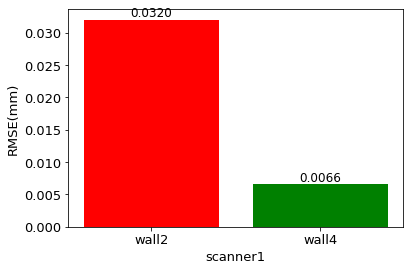

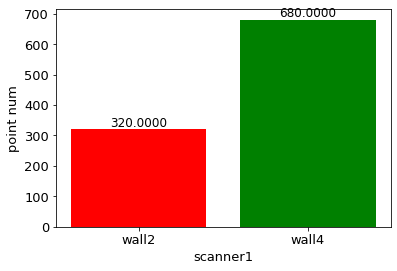

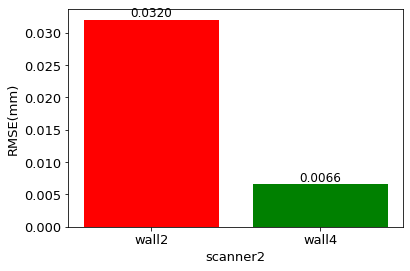

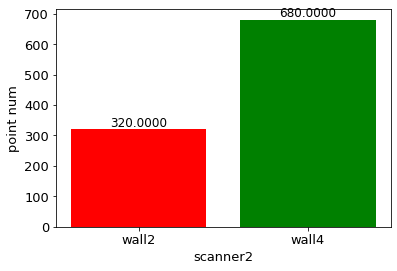

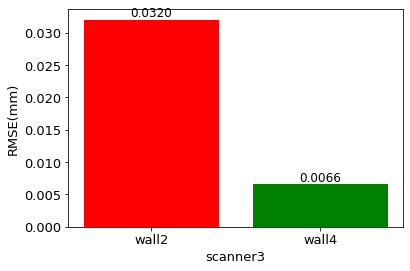

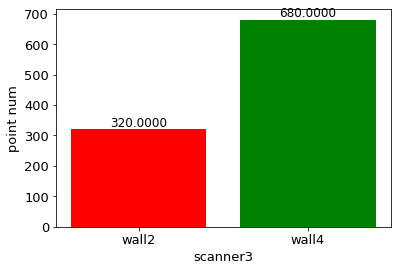

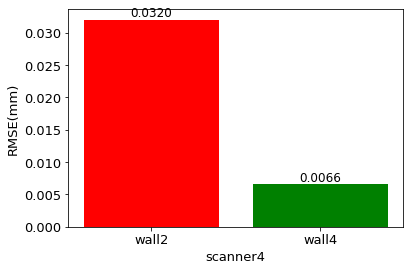

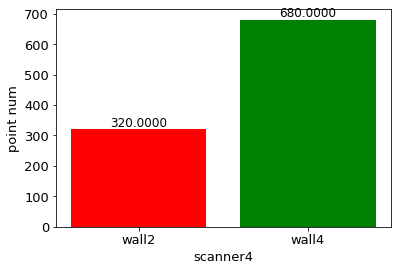

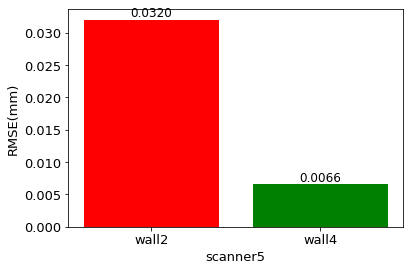

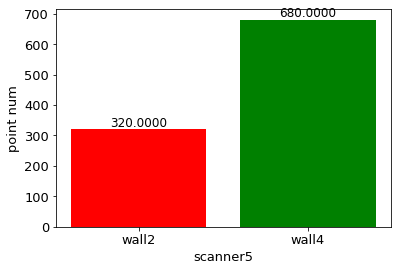

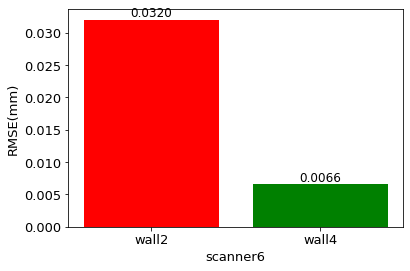

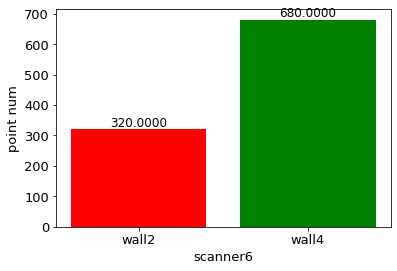

In [7]:
getRMSE()

In [ ]:
    k = [[],[],[],[]]
    for i in range(4):
        k[i].append(float(input(str(i+1) + ' 번째 x 시작 ')))
        k[i].append(float(input(str(i+1) + ' 번째 x 끝 ')))
        k[i].append(float(input(str(i+1) + ' 번째 y 시작 ')))
        k[i].append(float(input(str(i+1) + ' 번째 y 끝 ')))

In [ ]:
            if((x > 0.25 and x < 10.35) and (y > -0.35 and y < -0.25)):
                NP[i][5] = '벽체1'
            elif((x > 10.25 and x < 10.35) and (y < -0.25 and y > -20.35)):
                NP[i][5] = '벽체2'
            elif((x > -0.25 and x < 10.35) and (y > -20.35 and y < -20.25)):
                NP[i][5] = "벽체3"
            elif((x > -0.25 and x < 0.35) and (y < -0.25 and y > -20.35)):
                NP[i][5] = "벽체4"

In [ ]:
            if((x > k[0][0] and x < k[0][1]) and (y > k[0][2] and y < k[0][3])):
                NP[i][5] = '벽체1'
            elif((x > k[1][0] and x < k[1][1]) and (y < k[1][2] and y > k[1][3])):
                NP[i][5] = '벽체2'
            elif((x > k[2][0] and x < k[2][1]) and (y > k[2][2] and y < k[2][3])):
                NP[i][5] = "벽체3"
            elif((x > k[3][0] and x < k[3][1]) and (y < k[3][2] and y > k[3][3])):